In [2]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import h5py

In [3]:
from sklearn import metrics

In [4]:
from tensorflow import keras

In [62]:
from tensorflow.keras.optimizers import Adam

In [66]:
from sklearn.utils import shuffle

In [71]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [5]:
import sys

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
sys.path.append('../')

In [8]:
import datatools

In [9]:
import importlib

In [10]:
from glob import glob

In [11]:
SIM="/gpfs/slac/atlas/fs1/d/rafaeltl/public/Muon/simulation/"
DATA_LOC=f"{SIM}/stgc/atlas_nsw_pad_z0_stgc20Max1_bkgr_1_CovAngle_TRAIN/*.h5"

files=glob(DATA_LOC)

print(len(files))

135


In [12]:
data, dmat, Y, Y_mu, Y_hit, sig_keys = datatools.make_data_matrix(files, max_files=500, sort_by='z')

~~ Reading data... ~~


100%|██████████| 135/135 [01:15<00:00,  1.79it/s]


~~ Calculating occupancy information... ~~


100%|██████████| 387000/387000 [00:12<00:00, 30922.56it/s]

!!
I read 387000 events, of which 192000 have muon and 195000 do not
!!


In [13]:
import trainingvariables

In [14]:
X_pad = datatools.training_prep(dmat, sig_keys)

~~ Preparing padded matrix ~~


100%|██████████| 387000/387000 [00:26<00:00, 14365.37it/s]

Output data matrix shape: (387000, 20, 19)


In [15]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

linearized = True

In [16]:
X_prep = X_pad

In [17]:
vars_of_interest = np.zeros(X_prep.shape[2], dtype=bool)
training_vars = trainingvariables.tvars
for tv in training_vars:
    vars_of_interest[sig_keys.index(tv)] = 1

In [18]:
X = X_prep[:,:,vars_of_interest]
X_keys = np.array(sig_keys)[vars_of_interest]

In [21]:
model_loc = '../models/'
model_name = "MyTCN_10,3,1:10,3,1_30_CBNormTrue_DBNormFalse_ll1_ptype2_penXTrue_penATrue_bkgPenTrue_regBiasTrue_AvgPool"

In [22]:
keras_model = keras.models.load_model(model_loc+model_name,compile=False)

In [25]:
keras_preds = keras_model.predict(X, batch_size=1024)

In [43]:
keras_yhat = sigmoid(keras_preds[:,0])

In [28]:
mult_fact = max(data['ev_mu_x'])
mult_facta = max(data['ev_mu_theta'])

keras_x_reg = keras_preds[:,1]*mult_fact
keras_a_reg = keras_preds[:,2]*mult_facta

## Transform model to qkeras

In [31]:
import qkeras

In [29]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 7)]           0         
_________________________________________________________________
C1D_0 (Conv1D)               (None, 18, 10)            220       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 10)            40        
_________________________________________________________________
C1D_1 (Conv1D)               (None, 16, 10)            310       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 10)            40        
_________________________________________________________________
global_average_pooling1d (Gl (None, 10)                0         
_________________________________________________________________
F_dense_0 (Dense)            (None, 30)                330   

In [30]:
q_dict = {
    "QActivation": {
        "relu": "quantized_relu(4,0)"
    },
    "QConv1D": {
        "kernel_quantizer": "quantized_bits(4,0,1)",
        "bias_quantizer": "quantized_bits(4,0,1)"
    },
    "QDense": {
        "kernel_quantizer": "quantized_bits(3,0,1)",
        "bias_quantizer": "quantized_bits(3,0,1)"
    },
    
}

In [33]:
q_model = qkeras.utils.model_quantize(keras_model, q_dict, 4)

In [34]:
q_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 20, 7)]           0         
_________________________________________________________________
C1D_0 (QConv1D)              (None, 18, 10)            220       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 10)            40        
_________________________________________________________________
C1D_1 (QConv1D)              (None, 16, 10)            310       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 10)            40        
_________________________________________________________________
global_average_pooling1d (Gl (None, 10)                0         
_________________________________________________________________
F_dense_0 (QDense)           (None, 30)                330   

In [38]:
qkeras.estimate.print_qstats(q_model)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    C1D_0                         : 3780  (smult_4_8)
    C1D_1                         : 4800  (smult_4_4)
    F_dense_0                     : 300   (smult_3_4)
    output                        : 90    (smult_3_4)

Number of operation types in model:
    smult_3_4                     : 390
    smult_4_4                     : 4800
    smult_4_8                     : 3780

Weight profiling:
    C1D_0_weights                  : 210   (4-bit unit)
    C1D_0_bias                     : 10    (4-bit unit)
    C1D_1_weights                  : 300   (4-bit unit)
    C1D_1_bias                     : 10    (4-bit unit)
    F_dense_0_weights              : 300   (3-bit unit)
    F_dense_0_bias                 : 30    (3-bit unit)
    output_weights                 : 90    (3-bit unit)
    output_bias                    : 3     (3-bit unit)
    ----------------------------------------
    Total Bits                     :  3389

Weight sparsity:
... quantizing model

In [39]:
q_preds = q_model.predict(X, batch_size=1024)

q_yhat = sigmoid(q_preds[:,0])

q_x_reg = q_preds[:,1]*mult_fact
q_a_reg = q_preds[:,2]*mult_facta

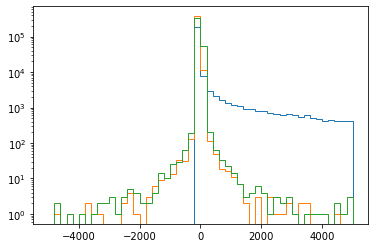

In [56]:
plt.Figure()
plt.hist( (q_yhat - keras_yhat)/keras_yhat, histtype='step', range=(-5000,5000), bins=50 )
plt.hist( (q_x_reg - keras_x_reg)/keras_x_reg, histtype='step', range=(-5000,5000), bins=50 )
plt.hist( (q_a_reg - keras_a_reg)/keras_a_reg, histtype='step', range=(-5000,5000), bins=50 )
plt.yscale('log')
plt.show()

In [58]:
import mlmodels as mlm

In [59]:
combloss = mlm.class_and_regr_loss(1,
                                   do_angle=1, 
                                   pen_type=2, pen_x=True, pen_a=True, bkg_pen_x=True, bkg_pen_a=True, linearized=True)

In [63]:
opt = Adam(learning_rate=0.01)

In [64]:
q_model.compile(loss=combloss, optimizer=opt)

In [69]:
data_ev_mu_x = (data['ev_mu_x'])/mult_fact
data_ev_mu_a = (data['ev_mu_theta'])/mult_facta

X_train, Y_clas_train, Y_xreg_train, Y_areg_train = shuffle(X, Y_mu, data_ev_mu_x, data_ev_mu_a)

Y_train = np.zeros( (Y_clas_train.shape[0], 3 ) ) 
Y_train[:,0] = Y_clas_train
Y_train[:,1] = Y_xreg_train
Y_train[:,2] = Y_areg_train

In [72]:
history = q_model.fit( X_train, Y_train,
                        callbacks = [
                                EarlyStopping(monitor='val_loss', patience=500, verbose=1),
                                ModelCheckpoint(f'qkeras_weights.h5', monitor='val_loss', verbose=True, save_best_only=True) ],
                        epochs=3000,
                        validation_split = 0.25,
                        batch_size=2**14,
                        #batch_size=1000000,
                        verbose=2
                       )

Epoch 1/3000
18/18 - 5s - loss: 2.6240 - val_loss: 2.0439

Epoch 00001: val_loss improved from inf to 2.04391, saving model to qkeras_weights.h5
Epoch 2/3000
18/18 - 1s - loss: 1.9522 - val_loss: 2.1927

Epoch 00002: val_loss did not improve from 2.04391
Epoch 3/3000
18/18 - 1s - loss: 1.7506 - val_loss: 2.0614

Epoch 00003: val_loss did not improve from 2.04391
Epoch 4/3000
18/18 - 1s - loss: 1.6790 - val_loss: 2.0140

Epoch 00004: val_loss improved from 2.04391 to 2.01398, saving model to qkeras_weights.h5
Epoch 5/3000
18/18 - 1s - loss: 1.5853 - val_loss: 1.8316

Epoch 00005: val_loss improved from 2.01398 to 1.83156, saving model to qkeras_weights.h5
Epoch 6/3000
18/18 - 1s - loss: 1.5206 - val_loss: 1.9702

Epoch 00006: val_loss did not improve from 1.83156
Epoch 7/3000
18/18 - 1s - loss: 1.5638 - val_loss: 1.6565

Epoch 00007: val_loss improved from 1.83156 to 1.65651, saving model to qkeras_weights.h5
Epoch 8/3000
18/18 - 1s - loss: 1.4583 - val_loss: 1.7886

Epoch 00008: val_lo

KeyboardInterrupt: 

In [73]:
q_preds = q_model.predict(X, batch_size=1024)

q_yhat = sigmoid(q_preds[:,0])

q_x_reg = q_preds[:,1]*mult_fact
q_a_reg = q_preds[:,2]*mult_facta

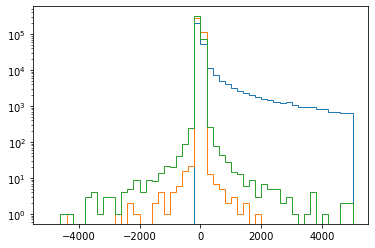

In [74]:
plt.Figure()
plt.hist( (q_yhat - keras_yhat)/keras_yhat, histtype='step', range=(-5000,5000), bins=50 )
plt.hist( (q_x_reg - keras_x_reg)/keras_x_reg, histtype='step', range=(-5000,5000), bins=50 )
plt.hist( (q_a_reg - keras_a_reg)/keras_a_reg, histtype='step', range=(-5000,5000), bins=50 )
plt.yscale('log')
plt.show()

In [78]:
this_cut=(Y_mu==1)
keras_mod_msex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], keras_x_reg[this_cut] )
keras_mod_msea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], keras_a_reg[this_cut] )
keras_mod_auc = metrics.roc_auc_score( Y_mu, keras_yhat )
keras_fpr, keras_tpr, keras_thresholds = metrics.roc_curve( Y_mu, keras_yhat )

In [79]:
this_cut=(Y_mu==1)
q_mod_msex = metrics.mean_squared_error(  data['ev_mu_x'][this_cut], q_x_reg[this_cut] )
q_mod_msea = metrics.mean_squared_error( data['ev_mu_theta'][this_cut], q_a_reg[this_cut] )
q_mod_auc = metrics.roc_auc_score( Y_mu, q_yhat )
q_fpr, q_tpr, q_thresholds = metrics.roc_curve( Y_mu, q_yhat )

In [80]:
q_mod_msex

87.70336808086051

In [81]:
keras_mod_msex

1.3026055154951957

In [82]:
keras_mod_auc

0.9999306730502137

In [83]:
q_mod_auc

0.998063632144765

In [84]:
keras_mod_msea

1.5535306131510264e-05

In [85]:
q_mod_msea

0.0014960198339481067

<ipython-input-89-0d1a34148515>:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(keras_tpr, 1./keras_fpr)
<ipython-input-89-0d1a34148515>:3: RuntimeWarning: divide by zero encountered in true_divide
  plt.semilogy(q_tpr, 1./q_fpr)


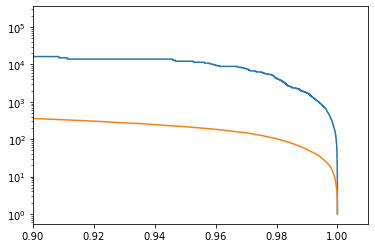

In [89]:
plt.Figure()
plt.semilogy(keras_tpr, 1./keras_fpr)
plt.semilogy(q_tpr, 1./q_fpr)
plt.xlim(0.9,1.01)
plt.show()